### ILI activiy prediction from Lat, Long

# Import module

In [164]:
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2

from datetime import datetime

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM 
from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)


import h5py

# convert series to supervised learning

In [165]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
Data since 2010 to 2015

In [166]:
#TO DO : create a function to preprocess the data
@memory.cache
def get_ili_data(data, normalize=True):
    
    df = read_csv(data, index_col=3, header=0)
    
    # manually specify column names
    df.columns = ['statename','activity_level','activity_level_label','season','weeknumber','Latitude','Longitude']
    df.index.name = 'date'
    
    # convert index to datetime
    df.index = pd.to_datetime(df.index, format='%b-%d-%Y')
    
    # manually remove the feature we don;t want to evaluate 
    df.drop(['statename', 'season', 'weeknumber','activity_level_label'], axis=1, inplace=True)
    
    if normalize:        
        min_max_scaler = MinMaxScaler()
        df['activity_level'] = min_max_scaler.fit_transform(df.activity_level.values.reshape(-1,1))
        df['Latitude'] = min_max_scaler.fit_transform(df.Latitude.values.reshape(-1,1))
        df['Longitude'] = min_max_scaler.fit_transform(df.Longitude.values.reshape(-1,1))
    return df

In [167]:
data = '../data/raw.csv'
#df = get_ili_data(data, normalize=True)
values = df.values
df = read_csv(data, index_col=3, header=0)

# manually specify column names
df.columns = ['statename','activity_level','activity_level_label','season','weeknumber','Latitude','Longitude']
df.index.name = 'date'
    
# convert index to datetime
df.index = pd.to_datetime(df.index, format='%b-%d-%Y')
    
# manually remove the feature we don;t want to evaluate 
df.drop(['statename', 'season', 'weeknumber','activity_level_label'], axis=1, inplace=True)

# summarize first 5 rows
print(df.head(5))
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

            activity_level   Latitude  Longitude
date                                            
2016-10-01               1  32.806671  -86.79113
2016-09-24               1  32.806671  -86.79113
2016-09-17               1  32.806671  -86.79113
2016-09-10               1  32.806671  -86.79113
2016-09-03               1  32.806671  -86.79113


# 2. Plot out the ILI activity level

In [168]:
def plot_ili(data):
    df = get_ili_data(data, normalize=True)
    print(df.head())
    plt.plot(df['activity_level'].values, color='red', label='ILI activity')
    plt.legend(loc='best')
    plt.show()
    
def plot_ili_group(data):
    df = get_ili_data(data, normalize=False)
    print(df.head())
    values = df.values
    # specify columns to plot
    groups = [0,1,2]
    i = 1
    # plot each column
    plt.figure()
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(values[:, group])
        plt.title(df.columns[group], y=0.5, loc='right')
        plt.legend(loc='best')
        i += 1
    plt.show()


            activity_level   Latitude  Longitude
date                                            
2016-10-01               1  32.806671  -86.79113
2016-09-24               1  32.806671  -86.79113
2016-09-17               1  32.806671  -86.79113
2016-09-10               1  32.806671  -86.79113
2016-09-03               1  32.806671  -86.79113


/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


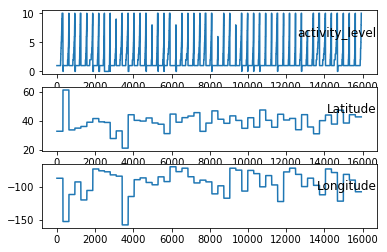

In [169]:
data = '../data/raw.csv'

# plot_ili(data)
plot_ili_group(data)

# frame as supervised learning

In [170]:
reframed = series_to_supervised(scaled, 8, 4)
print(reframed.head())

    var1(t-8)  var2(t-8)  var3(t-8)  var1(t-7)  var2(t-7)  var3(t-7)  \
8         0.1   0.290799   0.802429        0.1   0.290799   0.802429   
9         0.1   0.290799   0.802429        0.1   0.290799   0.802429   
10        0.1   0.290799   0.802429        0.1   0.290799   0.802429   
11        0.1   0.290799   0.802429        0.1   0.290799   0.802429   
12        0.1   0.290799   0.802429        0.1   0.290799   0.802429   

    var1(t-6)  var2(t-6)  var3(t-6)  var1(t-5)    ...       var3(t)  \
8         0.1   0.290799   0.802429        0.1    ...      0.802429   
9         0.1   0.290799   0.802429        0.1    ...      0.802429   
10        0.1   0.290799   0.802429        0.1    ...      0.802429   
11        0.1   0.290799   0.802429        0.1    ...      0.802429   
12        0.1   0.290799   0.802429        0.1    ...      0.802429   

    var1(t+1)  var2(t+1)  var3(t+1)  var1(t+2)  var2(t+2)  var3(t+2)  \
8         0.1   0.290799   0.802429        0.1   0.290799   0.802429

# split into train and test sets

In [171]:
values = reframed.values
n_train_weeks = round(0.8*len(values))
train = values[:n_train_weeks, :]
test = values[n_train_weeks:, :]

print ("Amount of training data = {}".format(1 * train.shape[0]))
print ("Amount of testing data = {}".format(1 * test.shape[0]))

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Amount of training data = 12738
Amount of testing data = 3184
(12738, 1, 35) (12738,) (3184, 1, 35) (3184,)


# design network

In [172]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
print(test_X.shape)

(3184, 1, 35)


# fit network

Train on 12738 samples, validate on 3184 samples
Epoch 1/50
1s - loss: 0.1268 - val_loss: 0.0635
Epoch 2/50
1s - loss: 0.0243 - val_loss: 0.0267
Epoch 3/50
1s - loss: 0.0241 - val_loss: 0.0156
Epoch 4/50
1s - loss: 0.0265 - val_loss: 0.0681
Epoch 5/50
1s - loss: 0.0183 - val_loss: 0.0194
Epoch 6/50
1s - loss: 0.0191 - val_loss: 0.0158
Epoch 7/50
1s - loss: 0.0208 - val_loss: 0.0112
Epoch 8/50
1s - loss: 0.0147 - val_loss: 0.0220
Epoch 9/50
1s - loss: 0.0144 - val_loss: 0.0119
Epoch 10/50
1s - loss: 0.0171 - val_loss: 0.0168
Epoch 11/50
1s - loss: 0.0161 - val_loss: 0.0090
Epoch 12/50
1s - loss: 0.0148 - val_loss: 0.0139
Epoch 13/50
1s - loss: 0.0161 - val_loss: 0.0172
Epoch 14/50
1s - loss: 0.0158 - val_loss: 0.0124
Epoch 15/50
1s - loss: 0.0160 - val_loss: 0.0142
Epoch 16/50
1s - loss: 0.0173 - val_loss: 0.0216
Epoch 17/50
1s - loss: 0.0192 - val_loss: 0.0320
Epoch 18/50
1s - loss: 0.0124 - val_loss: 0.0106
Epoch 19/50
1s - loss: 0.0131 - val_loss: 0.0122
Epoch 20/50
1s - loss: 0.0151

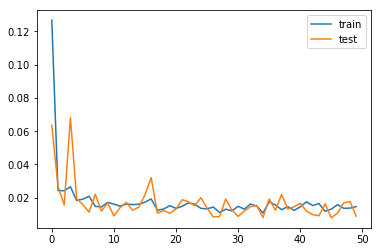

In [173]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction

In [174]:
test_X.shape

(3184, 1, 35)

In [175]:
# make a prediction
yhat = model.predict(test_X)
test_  X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))  
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: operands could not be broadcast together with shapes (3184,35) (3,) (3184,35) 

# 10. Save for consistency

In [ ]:
# model.save('LSTM_Stock_prediction-20170429.h5')